# 0. Run Jaris and Roshni's scripts

      gloss                                          instances
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
(2000, 2)


/tmp/ipykernel_668648/1290978507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['samples_num'] = selected_df['video_id'].apply(len)


20.0


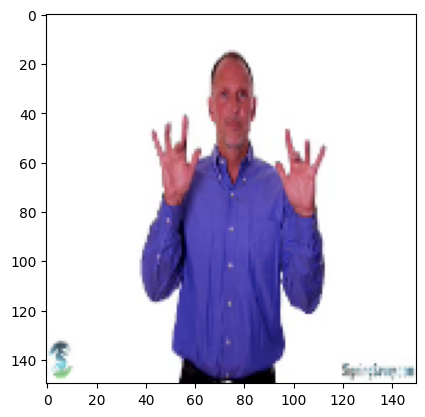

In [7]:
%run data_preprocessing_RK.ipynb


In [9]:
%run data_preprocessing\ Jaris.ipynb


      gloss                                          instances
0      book  [{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...
1     drink  [{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...
2  computer  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
3    before  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
4     chair  [{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...
(2000, 2)
[1, 7, 14, 16, 18, 41, 52, 62, 63, 64] 88.0
(10, 150, 150, 3)
0
[0, 28, 49, 58, 65, 68, 69, 78, 88, 91] 101.0
(10, 150, 150, 3)
1
[3, 6, 7, 20, 21, 34, 41, 53, 55, 60] 72.0
(10, 150, 150, 3)
2
[16, 20, 30, 33, 35, 55, 76, 83, 87, 90] 107.0
(10, 150, 150, 3)
3
[2, 6, 23, 25, 27, 40, 44, 45, 58, 68] 81.0
(10, 150, 150, 3)
4
[0, 1, 2, 7, 8, 11, 12, 32, 34, 36] 43.0
(10, 150, 150, 3)
5
[1, 6, 13, 14, 20, 23, 36, 42, 44, 47] 57.0
(10, 150, 150, 3)
6
[4, 13, 14, 16, 19, 20, 21, 30, 32, 33] 43.0
(10, 150, 150, 3)
7
[2, 5, 9, 12, 22, 32, 39, 41, 45, 46] 53.0
(10, 150, 150, 3)
8
[0, 4, 5, 12, 14, 23, 25, 30, 37, 3

[h264 @ 0x5586ea25b740] Invalid NAL unit size (745 > 472).
[h264 @ 0x5586ea25b740] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5586ea495c40] stream 1, offset 0x3b468: partial file


(10, 150, 150, 3)
166
[1, 2, 10, 21, 29, 37, 43, 44, 49, 72] 79.0
(10, 150, 150, 3)
167
[0, 1, 7, 32, 39, 49, 57, 73, 78, 87] 94.0
(10, 150, 150, 3)
168
[0, 3, 6, 7, 8, 18, 19, 22, 23, 26] 34.0
(10, 150, 150, 3)
169
[1, 10, 11, 15, 31, 35, 39, 41, 42, 49] 55.0
(10, 150, 150, 3)
170
[4, 8, 9, 11, 14, 37, 39, 40, 46, 59] 71.0
(10, 150, 150, 3)
171
[1, 4, 6, 7, 8, 15, 16, 17, 24, 28] 40.0
(10, 150, 150, 3)
172
[4, 7, 17, 36, 37, 39, 43, 57, 70, 77] 86.0
(10, 150, 150, 3)
173
[1, 2, 9, 15, 17, 23, 30, 36, 39, 43] 56.0
(10, 150, 150, 3)
174
[0, 1, 3, 4, 6, 7, 12, 19, 23, 25] 35.0
(10, 150, 150, 3)
175
[0, 7, 8, 11, 12, 19, 21, 22, 23, 24] 35.0
(10, 150, 150, 3)
176
[9, 10, 12, 17, 18, 20, 29, 30, 33, 43] 50.0
(10, 150, 150, 3)
177
[5, 36, 45, 50, 53, 57, 73, 74, 80, 81] 88.0
(10, 150, 150, 3)
178
[0, 2, 4, 10, 11, 13, 14, 19, 24, 29] 35.0
(10, 150, 150, 3)
179
[1, 4, 7, 9, 11, 12, 16, 17, 19, 21] 31.0
(10, 150, 150, 3)
180
[2, 4, 9, 13, 32, 38, 54, 55, 61, 83] 101.0
(10, 150, 150, 3)
181
[0

In [65]:
X = results
y = y_cat


# 1. Import libraries

In [27]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import json


In [28]:
input_shape=(150,150,3)


In [59]:
# def add_final_layers(base_model):
#     model = Sequential()
#     model.add(base_model)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(10, activation="relu"))
#     model.add(layers.Reshape((-1,10)))
#     model.add(layers.SimpleRNN(units=10, activation="tanh", return_sequences=True))
#     model.add(layers.SimpleRNN(units=5, activation="tanh", return_sequences=True))
#     model.add(layers.Dense(20, activation="softmax"))
#     return model


# 2. Load MobileNet

### 1.1 MobileNet

In [29]:
def load_model():
    model = MobileNet(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling='avg',  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classificatio
    )
    return model

model_mobilenet = load_model()
model_mobilenet.trainable = False


In [30]:
model_mobilenet.summary()
# model_mobilenet.layers


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                         

In [31]:
layers_outputs = [layer.output for layer in model_mobilenet.layers]
layers_outputs


[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv1_relu')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv_dw_1_relu')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1_bn')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv_pw_1_relu')>,
 <KerasTensor: shape=(None, 76, 76, 64) dtype=float32 (created by layer 'conv_pad_2')>,
 <KerasTensor: shape=(None, 37,

### 1.2 MobileNetv3Small

In [27]:
def load_model():
    model = MobileNetV3Small(
        include_top=False,  # Exclude fully connected layers
        weights='imagenet',  # Use pre-trained weights
        input_shape=input_shape,  # Set your image input shape
        pooling=None,  # Use default global average pooling
        classes=20,  # Adjust based on your task's number of classes
        classifier_activation='softmax'  # Softmax activation for classification
    )
    return model

model_mobilenetv3 = load_model()
model_mobilenetv3.trainable = False


4334752/4334752 [==============================] - 1s 0us/step


In [28]:
model_mobilenetv3.summary()


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

# 3. Define RNN and Compile

In [32]:
def model_initialize_simple():
    model = Sequential()
    model.add(layers.SimpleRNN(units=256, activation="tanh", input_shape=(10,1024), return_sequences=True))
    model.add(layers.SimpleRNN(units=128, activation="tanh"))
    model.add(layers.Dense(20, activation="softmax"))
    return model

model = model_initialize_simple()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10, 256)           327936    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 379,796
Trainable params: 379,796
Non-trainable params: 0
_________________________________________________________________


In [33]:
learning_rate = 1e-4

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["accuracy"]
)


# 4. Dry run on sample

### 4.1 Prepare X

In [131]:
import cv2
X = [[],[]]

for i in range(1,3):
    image = cv2.imread(f'../data_test/X{i}.jpg')

    width, height = 256, 256
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    #produce resized jpy
    cv2.imwrite(f'../data_test/X{i}_resized.jpg', resized_image)

    #produce matrix and input into X
    image_matrix = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    for j in range(10):
        X[i-1].append(image_matrix)


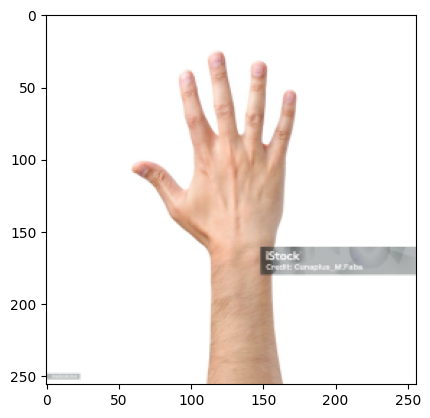

In [132]:
plt.imshow(X[0][3])


In [187]:
X_features = []

for i in range(len(X)):
    features = model_mobilenet.predict(X[i])
    X_features.append(features)

features.shape


1/1 [==============================] - 0s 93ms/step


(10, 1024)

In [219]:
X_features = tf.convert_to_tensor(X_features)
X_features.shape


TensorShape([2, 10, 1024])

### 4.2 Prepare y

In [235]:
# y = ["like", "like"]
y = [3, 1]
y = to_categorical(y, num_classes=20)
y.shape


(2, 20)

# 5. Train/val split

In [66]:
X_preprocessed = preprocess_input(X)
X_preprocessed.shape


(219, 10, 150, 150, 3)

In [67]:
X_features = []

for i in range(len(X_preprocessed)):
    features = model_mobilenet.predict(X_preprocessed[i])
    X_features.append(features)

features.shape


1/1 [==============================] - 0s 53ms/step


(10, 1024)

In [62]:
z = [1,2,3,4,5,6,8]


In [70]:
X_features[0].shape


(10, 1024)

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_features, y, train_size=0.8, random_state=42)


In [72]:
X_train = tf.convert_to_tensor(X_train)
print(X_train.shape)
X_val = tf.convert_to_tensor(X_val)
print(X_val.shape)


(175, 10, 1024)
(44, 10, 1024)


In [73]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/30
22/22 [==============================] - 0s 10ms/step - loss: 0.9090 - accuracy: 0.8057 - val_loss: 1.0039 - val_accuracy: 0.7727
Epoch 2/30
22/22 [==============================] - 0s 8ms/step - loss: 0.6053 - accuracy: 0.8571 - val_loss: 1.0474 - val_accuracy: 0.7727
Epoch 3/30
22/22 [==============================] - 0s 9ms/step - loss: 0.3902 - accuracy: 0.9486 - val_loss: 1.0189 - val_accuracy: 0.7727
Epoch 4/30
22/22 [==============================] - 0s 9ms/step - loss: 0.2681 - accuracy: 0.9829 - val_loss: 1.0093 - val_accuracy: 0.7727
Epoch 5/30
22/22 [==============================] - 0s 8ms/step - loss: 0.1904 - accuracy: 1.0000 - val_loss: 1.0054 - val_accuracy: 0.7727
Epoch 6/30
22/22 [==============================] - 0s 9ms/step - loss: 0.1576 - accuracy: 1.0000 - val_loss: 1.0017 - val_accuracy: 0.7727
Epoch 7/30
22/22 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 1.0000 - val_loss: 1.0078 - val_accuracy: 0.7727
Epoch 8/30
22/22 [=

(0.0, 1.1)

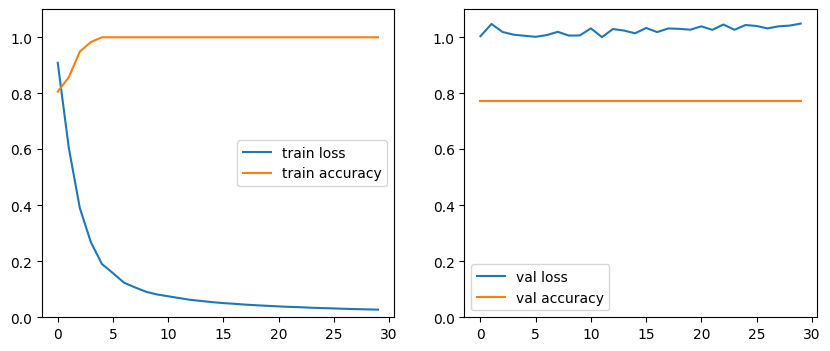

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(history.__dict__["history"]["loss"], label="train loss")
ax1.plot(history.__dict__["history"]["accuracy"], label="train accuracy")
ax1.legend()
ax1.set_ylim(0,1.1)

ax2.plot(history.__dict__["history"]["val_loss"], label="val loss")
ax2.plot(history.__dict__["history"]["val_accuracy"], label="val accuracy")
ax2.legend()
ax2.set_ylim(0,1.1)


# 6. Evaluate